In [4]:
from pylab import *
%matplotlib inline

In [5]:
def f(x, omega =1.):
    return sin(x*omega)

def g(h_de_x,x, args = []):
    if len([args]) == 0:
        return exp(-x)*h_de_x(x)
    else:
        return exp(-x)*h_de_x(x,args)

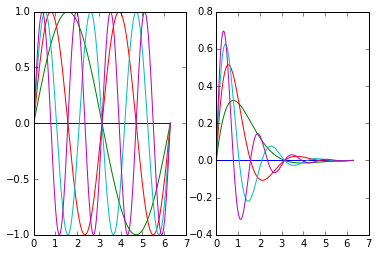

In [6]:
x = linspace(0,2*pi,200)
for i in range(5):
    subplot(121)
    plot(x,f(x,i))
    r = f(x,i)
    subplot(122)
    plot(x,g(f,x,i))
show()

In [7]:
def int_rk4(ec,p_ini,x,args=0,h=0.01):
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    if args==0:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    else:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    return tiempos,sol    

Consideramos ahora el caso de un tiro parabólico con resistencia al aire. La resistencia por la fricción provoca una aceleración que esta dada por: $$\dot{\vec{u}}=-\frac{g}{m}\hat{j}-\frac{f}{m}\frac{\vec{u}}{||\vec{u}||}$$

In [8]:
def ec_mov(r_v, t, fric = 0., g = 9.81, m = 1.):
    u = sqrt(r_v[2]**2 + r_v[3]**2)
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0.:
        dvx = 0.
        dvy = -g/m
    else:
        dvx = -fric([r_v[2], r_v[3]])[0]
        dvy = -g/m -fric([r_v[2], r_v[3]])[1]
    return array([dx,dy,dvx,dvy])

def fricNul(v):
    return array([0,0])
def fricV1(v, gamma = 0.1):
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y])
def fricV2(v, gamma = 0.1):
    norma = sqrt(v[0]**2+v[1]**2)
    f_x = gamma*norma*v[0]
    f_y = gamma*norma*v[1]
    return array([f_x,f_y])

In [9]:
def movPlaneta(x,t):
    r = sqrt(x[0]**2 + x[1]**2)
    drx = x[2]
    dry = x[3]
    dvx = -x[0]/r**3
    dvy = -x[1]/r**3
    return array([drx,dry,dvx,dvy])

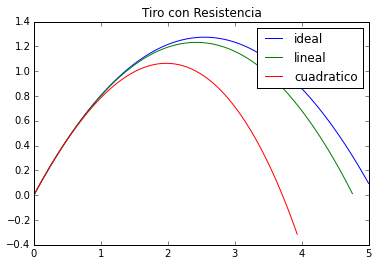

In [10]:
p = [0,0,5,5]
t,sol_id = int_rk4(ec_mov, p, [0,1])
plot(sol_id[:,0], sol_id[:,1],label="ideal")
t,sol_fr = int_rk4(ec_mov, p, [0,1], fricV1)
plot(sol_fr[:,0], sol_fr[:,1], label = "lineal")
t,sol_fr = int_rk4(ec_mov, p, [0,1], fricV2)
plot(sol_fr[:,0], sol_fr[:,1], label = "cuadratico")
title('Tiro con Resistencia')
legend()
show()

Ahora deseamos hallar el punto donde la solución cruza el eje x (y=0) para hacer un rebote del proyectil. Primero hacemos la integración hasta el punto en hay un cambio de signo en y 

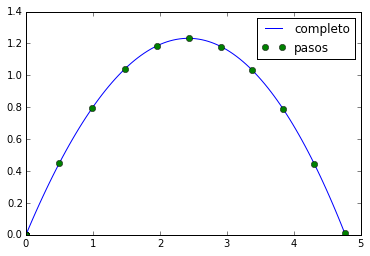

In [11]:
inicio = [0,0,5,5]
N=500
trayectoria=zeros((N,len(inicio)))
mi_dt=.1
trayectoria[0,:]=array(inicio)
for i in range(N):
    t,sol_dt=int_rk4(ec_mov,inicio,[0,mi_dt],fricV1)
    if sol_dt[-1,:][1]<0:
        break
    inicio = sol_dt[-1,:] #solo guarda el punto final del  proceso y lo usa como el nuevo inicio
    trayectoria[i+1,:]=inicio
t,sol_lin = int_rk4(ec_mov, p, [0,1],fricV1)
plot(sol_lin[:,0], sol_lin[:,1],label="completo")
plot(trayectoria[:,0],trayectoria[:,1],'o',label="pasos")
legend()
show()

Ahora utilizamos el método de bisección para poder hallar el cruze en el último ciclo de integración

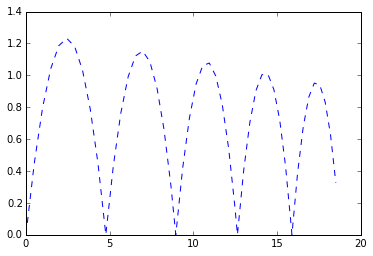

In [12]:
inicio = [0,0,5,5]
N = 50
trayectoria = zeros((N,len(inicio)))
mi_dt = .1
trayectoria[0,:] = array(inicio)
for i in range(N-1):
    t,sol_dt = int_rk4(ec_mov,trayectoria[i,:],[0,mi_dt],fricV1)
    if sol_dt[-1,:][1] < 0:
        #print "buscando punto de rebote"
        dt_busqueda = mi_dt/2
        y_izq = trayectoria[i,:]
        t,sol = int_rk4(ec_mov,trayectoria[i,:],[0,dt_busqueda],fricV1)
        y_med = sol[-1,:]
        #print y_med
        while abs(y_izq[1]) > 1e-5:
            if y_izq[1]*y_med[1] < 0:
                reinicio = y_izq
            else:
                reinicio = y_med
            dt_busqueda = dt_busqueda/2
            t,sol = int_rk4(ec_mov,reinicio,[0,dt_busqueda],fricV1)
            y_izq = reinicio
            y_med = sol[-1,:]
        y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])    
        trayectoria[i+1,:] = y_izq
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]

plot(trayectoria[:,0],trayectoria[:,1],'--')
show()

Ahora agrupamos todos el código nuevo en una función:

In [13]:
def rebote(r_v_i,mi_dt): 
    dt_busqueda=mu_dt/2
    y_izq=r_v_i
    t,sol_dt=int_rk4(ec_mov,trayectoria[i,:],[0,mi_dt],fricV1)
    y_med=sol[-1,:]                                        
    while abs(y_izq[1])>1e-5:
        if y_izq[1]*y_med[1]<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda =dt_busqueda/2
        t,sol = int_rk4(ec_mov,trayectoria[i,:],[0,dt_busqueda],fricV1)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[0]])
    return y_izq

## Movimiento de 3 cuerpos: caso particular

Deseamos realizar la integración del movimiento para un problema gravitacional. Para esto consideramos 3 cuerpos con posiciones respectivas denotadas por $\vec{x}_S$ (sol), $\vec{x}_p$ (planeta) y $\vec{x}_s$. Sus masas respectivas son $M_S,m_p,m_s$. Para simplificar el problema consideramos que el centro de masa se encuentra en el sol y todo el movimiento ocurre en un plano, que tiene al sol como origen. Entonces las ecuaciones de movimiento serán solo para $\vec{x}_p$ y $\vec{x}_s$ y estan dadas por:

$\begin{cases} \ddot{\vec{x}_p}=-\frac{\vec{x}_p}{|x_p|^3}+\frac{m_p}{M_S} \\ \end{cases}$

In [47]:
def mov(xp_xs,t,a_b=[0,0]): #xp_xs=(xp,yp,vxp,vyp,xs,ys,vxs,vys) ,a y b son las relaciones entre las masas
    rp = sqrt(xp_xs[0]**2 + xp_xs[1]**2)
    rs = sqrt(xp_xs[4]**2 + xp_xs[5]**2)
    dif_xpxs = xp_xs[0:2]-xp_xs[4:6]
    dist_xpxs = sqrt(dif_xpxs[0]**2+dif_xpxs[1]**2)

    dxp,dyp = xp_xs[2],xp_xs[3]
    dvxp = -xp_xs[0]/(rp**3) - (a_b[0]*dif_xpxs[0])/(dist_xpxs**3)
    dvyp = -xp_xs[1]/(rp**3) - (a_b[0]*dif_xpxs[1])/(dist_xpxs**3)
    
    dxs,dys = xp_xs[6],xp_xs[7]
    dvxs = -xp_xs[4]/(rs**3) + (a_b[1]*dif_xpxs[0])/(dist_xpxs**3)
    dvys = -xp_xs[5]/(rs**3) + (a_b[1]*dif_xpxs[1])/(dist_xpxs**3)
    return array([dxp,dyp,dvxp,dvyp,dxs,dys,dvxs,dvys])

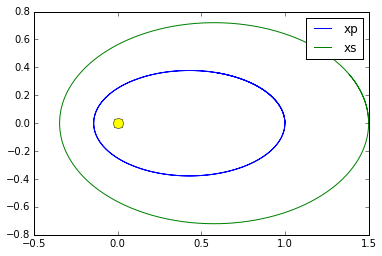

In [59]:
p_ini = [1,0,0,0.5,1.5,0,0,0.5]
t,r = int_rk4(mov,p_ini,[0,2*pi])
plot(r[:,0],r[:,1],label='xp')
plot(r[:,4],r[:,5],label='xs')
plot([0],[0],'o',color='yellow',markersize=10)
legend()
show()

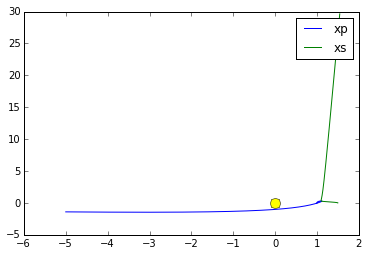

In [64]:
p_ini = [1,0,0,1,1.5,0,0,0.5]
t,r = int_rk4(mov,p_ini,[0,2*pi],h=0.01,args=[.5,1])
plot(r[:,0],r[:,1],label='xp')
plot(r[:,4],r[:,5],label='xs')
plot([0],[0],'o',color='yellow',markersize=10)
legend()
show()